# Financial Data Insights Dashboard

# Pulling and Uploading the Data

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [17]:
companies = pd.read_csv("/Users/averymaslin/Documents/Personal Project/sp500_companies.csv")
tickers = companies['Symbol'].dropna().unique().tolist()

#Download data from Yahoo Finance
sample_tickers = ["AAPL", "MSFT", "AMZN"]   
start_date = "2018-01-01"
end_date   = "2023-12-31"

all_data = []

for ticker in sample_tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data = data.reset_index()
        data['Symbol'] = ticker

        if "Adj Close" in data.columns:
            data.rename(columns={"Adj Close": "Price"}, inplace=True)
        else:
            data.rename(columns={"Close": "Price"}, inplace=True)

        keep_cols = ["Date","Symbol","Price","Close","High","Low","Open","Volume"]
        data = data[[col for col in keep_cols if col in data.columns]]

        all_data.append(data)
        print(f"Downloaded {ticker} with {data.shape[0]} rows")

        time.sleep(0.2)  

    except Exception as e:
        print(f"Failed for {ticker}: {e}")

stocks = pd.concat(all_data, ignore_index=True)


# Save to csv
stocks.to_csv("/Users/averymaslin/Documents/Personal Project/sp500_stocks.csv", index=False)
print("Saved sp500_stocks.csv with shape:", stocks.shape)

/var/folders/r9/z3dx1np963358ckd017hj93w0000gn/T/ipykernel_61040/2136198369.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Downloaded AAPL with 1509 rows


/var/folders/r9/z3dx1np963358ckd017hj93w0000gn/T/ipykernel_61040/2136198369.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Downloaded MSFT with 1509 rows


/var/folders/r9/z3dx1np963358ckd017hj93w0000gn/T/ipykernel_61040/2136198369.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Downloaded AMZN with 1509 rows
Saved sp500_stocks.csv with shape: (4527, 17)


In [21]:
#Reloading and Reshaping Our Data
stocks_wide = pd.read_csv("/Users/averymaslin/Documents/Personal Project/sp500_stocks.csv")
tickers = [col for col in stocks_wide.iloc[0, 2:].unique() if pd.notnull(col)]

stocks_wide = stocks_wide.drop(0).reset_index(drop=True)
stocks_wide['Date'] = pd.to_datetime(stocks_wide['Date'])

all_data = []
for i, ticker in enumerate(tickers):
    cols = [
        'Date',
        f'Price{"" if i==0 else "."+str(i)}',
        f'High{"" if i==0 else "."+str(i)}',
        f'Low{"" if i==0 else "."+str(i)}',
        f'Open{"" if i==0 else "."+str(i)}',
        f'Volume{"" if i==0 else "."+str(i)}'
    ]
    df = stocks_wide[cols].copy()
    df.columns = ['Date','Price','High','Low','Open','Volume']
    df['Symbol'] = ticker
    all_data.append(df)

stocks_long = pd.concat(all_data, ignore_index=True)

print("Long format shape:", stocks_long.shape)
print(stocks_long.head())
print(stocks_long['Symbol'].value_counts())

Long format shape: (13581, 7)
        Date               Price                High                Low  \
0 2018-01-02  40.380985260009766  40.390364016042994  39.67772878930773   
1 2018-01-03  40.373966217041016   40.91781978294062  40.31067568933175   
2 2018-01-04    40.5615119934082  40.664656907181175  40.33881469882533   
3 2018-01-05   41.02329635620117   41.11003018101677  40.56618034076445   
4 2018-01-08   40.87092590332031   41.16629235198512  40.77246684348444   

                 Open       Volume Symbol  
0  39.888707876686766  102223600.0   AAPL  
1   40.44429260255542  118071600.0   AAPL  
2   40.44664541635204   89738400.0   AAPL  
3   40.65760354385179   94640000.0   AAPL  
4   40.87092590332031   82271200.0   AAPL  
AAPL    4527
MSFT    4527
AMZN    4527
Name: Symbol, dtype: int64


# Data Preprocessing

In [22]:
#1. Data Quality Assessment
print("Dataset shape:", stocks_long.shape)
print("\nMissing values per column:\n", stocks_long.isnull().sum())
print("\nDescriptive stats (Price & Volume):\n", stocks_long[['Price','Volume']].describe())

Dataset shape: (13581, 7)

Missing values per column:
 Date         0
Price     9054
High      9054
Low       9054
Open      9054
Volume    9054
Symbol       0
dtype: int64

Descriptive stats (Price & Volume):
                     Price      Volume
count                4527        4527
unique               4457        4500
top     125.9800033569336  63482000.0
freq                    3           2


In [23]:
#2. Handling Missing Values
stocks_clean = stocks_long.copy()

# Check numeric variables
stocks_clean['Price']  = pd.to_numeric(stocks_clean['Price'], errors='coerce')
stocks_clean['Volume'] = pd.to_numeric(stocks_clean['Volume'], errors='coerce')

# Drop rows where critical fields are missing
stocks_clean = stocks_clean.dropna(subset=['Price','Volume'])

# Check again
print("Shape after cleaning:", stocks_clean.shape)
print("\nMissing values per column:\n", stocks_clean.isnull().sum())
print("\nRow counts per ticker:\n", stocks_clean['Symbol'].value_counts())

Shape after cleaning: (4527, 7)

Missing values per column:
 Date      0
Price     0
High      0
Low       0
Open      0
Volume    0
Symbol    0
dtype: int64

Row counts per ticker:
 AAPL    1509
MSFT    1509
AMZN    1509
Name: Symbol, dtype: int64


In [24]:
#3. Outlier Handling
stocks_clean['Return'] = stocks_clean.groupby('Symbol')['Price'].pct_change()
return_std = stocks_clean['Return'].std(skipna=True)

stocks_no_outliers = stocks_clean[
    (stocks_clean['Return'].abs() <= 3 * return_std) | (stocks_clean['Return'].isna())
].copy()

print("\nReturn std dev:", return_std)
print("Rows before filter:", stocks_clean.shape)
print("Rows after filter:", stocks_no_outliers.shape)


Return std dev: 0.02044630148118014
Rows before filter: (4527, 8)
Rows after filter: (4457, 8)


In [25]:
#4. Normalization using Min/Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stocks_no_outliers['Price_Scaled'] = scaler.fit_transform(stocks_no_outliers[['Price']])

print("\nScaled price sample:\n",
      stocks_no_outliers[['Symbol','Date','Price','Price_Scaled']].head())


Scaled price sample:
   Symbol       Date      Price  Price_Scaled
0   AAPL 2018-01-02  40.380985      0.015880
1   AAPL 2018-01-03  40.373966      0.015860
2   AAPL 2018-01-04  40.561512      0.016407
3   AAPL 2018-01-05  41.023296      0.017754
4   AAPL 2018-01-08  40.870926      0.017309


In [26]:
#5. Feature Engineering
result = []

for sym, df in stocks_no_outliers.groupby('Symbol'):
    df = df.copy()
    
    # Lags (previous day / previous 5 days)
    df['Lag_1']  = df['Price'].shift(1)
    df['Lag_5']  = df['Price'].shift(5)
    
    # Rolling stats (20-day moving average and volatility)
    df['MA_20']  = df['Price'].rolling(20).mean()
    df['Vol_20'] = df['Return'].rolling(20).std()
    
    result.append(df)

stocks_final = pd.concat(result, ignore_index=True)

print(stocks_final[['Date','Symbol','Price','Return','Lag_1','Lag_5','MA_20','Vol_20','Price_Scaled']].head(25))

         Date Symbol      Price    Return      Lag_1      Lag_5      MA_20  \
0  2018-01-02   AAPL  40.380985       NaN        NaN        NaN        NaN   
1  2018-01-03   AAPL  40.373966 -0.000174  40.380985        NaN        NaN   
2  2018-01-04   AAPL  40.561512  0.004645  40.373966        NaN        NaN   
3  2018-01-05   AAPL  41.023296  0.011385  40.561512        NaN        NaN   
4  2018-01-08   AAPL  40.870926 -0.003714  41.023296        NaN        NaN   
5  2018-01-09   AAPL  40.866241 -0.000115  40.870926  40.380985        NaN   
6  2018-01-10   AAPL  40.856865 -0.000229  40.866241  40.373966        NaN   
7  2018-01-11   AAPL  41.088943  0.005680  40.856865  40.561512        NaN   
8  2018-01-12   AAPL  41.513241  0.010326  41.088943  41.023296        NaN   
9  2018-01-16   AAPL  41.302277 -0.005082  41.513241  40.870926        NaN   
10 2018-01-17   AAPL  41.984425  0.016516  41.302277  40.866241        NaN   
11 2018-01-18   AAPL  42.021919  0.000893  41.984425  40.856865 

In [27]:
#Preview Final Dataset
print("\nFinal dataset preview:\n",
      stocks_final[['Date','Symbol','Price','Return','Lag_1','Lag_5','MA_20','Vol_20','Price_Scaled']].head(20))


Final dataset preview:
          Date Symbol      Price    Return      Lag_1      Lag_5      MA_20  \
0  2018-01-02   AAPL  40.380985       NaN        NaN        NaN        NaN   
1  2018-01-03   AAPL  40.373966 -0.000174  40.380985        NaN        NaN   
2  2018-01-04   AAPL  40.561512  0.004645  40.373966        NaN        NaN   
3  2018-01-05   AAPL  41.023296  0.011385  40.561512        NaN        NaN   
4  2018-01-08   AAPL  40.870926 -0.003714  41.023296        NaN        NaN   
5  2018-01-09   AAPL  40.866241 -0.000115  40.870926  40.380985        NaN   
6  2018-01-10   AAPL  40.856865 -0.000229  40.866241  40.373966        NaN   
7  2018-01-11   AAPL  41.088943  0.005680  40.856865  40.561512        NaN   
8  2018-01-12   AAPL  41.513241  0.010326  41.088943  41.023296        NaN   
9  2018-01-16   AAPL  41.302277 -0.005082  41.513241  40.870926        NaN   
10 2018-01-17   AAPL  41.984425  0.016516  41.302277  40.866241        NaN   
11 2018-01-18   AAPL  42.021919  0.0008

# Time Series Decomposition and ADF Test for Stationarity

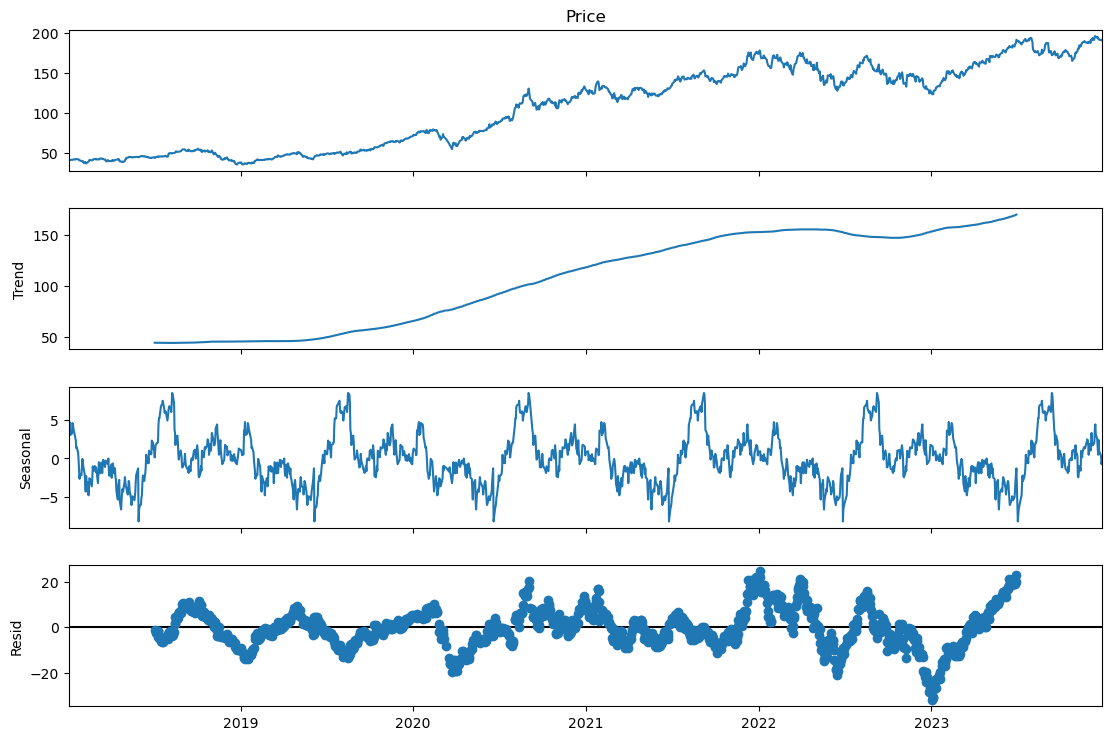

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

#AAPL only
aapl = stocks_final[stocks_final['Symbol'] == 'AAPL'].copy()
aapl = aapl.set_index('Date').sort_index()

# Decompose using Price
decomposition = seasonal_decompose(aapl['Price'], model='additive', period=252)  #252 trading days per year

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller

# Test stationarity on Price
result_price = adfuller(aapl['Price'].dropna())
print("ADF Statistic (Price):", result_price[0])
print("p-value:", result_price[1])

# Test stationarity on Returns
result_return = adfuller(aapl['Return'].dropna())
print("\nADF Statistic (Return):", result_return[0])
print("p-value:", result_return[1])

ADF Statistic (Price): -0.5520368639191485
p-value: 0.8814556858184625

ADF Statistic (Return): -39.50953909830078
p-value: 0.0


ADF Statistic (Differenced Price): -28.46151324807658
p-value: 0.0


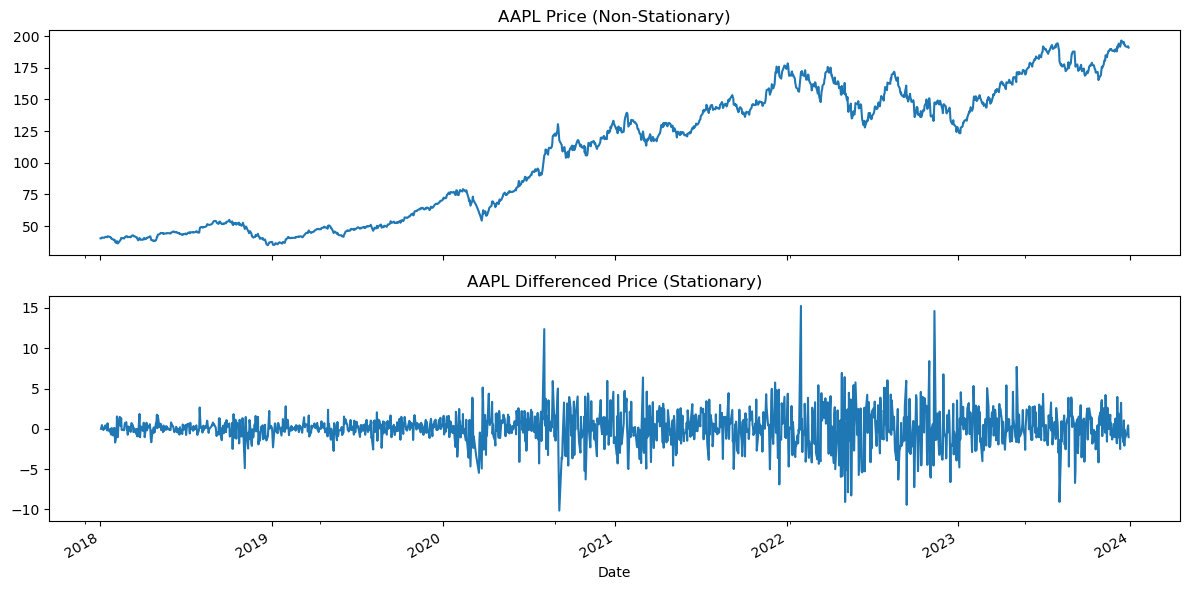

In [30]:
#Differencing Step on Price
aapl = stocks_final[stocks_final['Symbol'] == 'AAPL'].copy()
aapl = aapl.set_index('Date').sort_index()

# Apply first differencing
aapl['Price_diff'] = aapl['Price'].diff()

# Run ADF test on differenced price
from statsmodels.tsa.stattools import adfuller
adf_result_diff = adfuller(aapl['Price_diff'].dropna())
print("ADF Statistic (Differenced Price):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])

# Plot comparison
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)
aapl['Price'].plot(ax=ax[0], title="AAPL Price (Non-Stationary)")
aapl['Price_diff'].plot(ax=ax[1], title="AAPL Differenced Price (Stationary)")
plt.tight_layout()
plt.show()

# Machine Learning Using Logistic Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

ml_data = stocks_final.copy()
ml_data['Target'] = (ml_data['Return'] > 0).astype(int)

# Drop NaN rows from lag/rolling features
ml_data = ml_data.dropna(subset=['Lag_1','Lag_5','MA_20','Vol_20'])

# Features and target
X = ml_data[['Lag_1','Lag_5','MA_20','Vol_20']]
y = ml_data['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

#Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Confusion Matrix:
 [[357  67]
 [357  99]]

Classification Report:
               precision    recall  f1-score   support

           0      0.500     0.842     0.627       424
           1      0.596     0.217     0.318       456

    accuracy                          0.518       880
   macro avg      0.548     0.530     0.473       880
weighted avg      0.550     0.518     0.467       880



# Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

X = ml_data[['Lag_1','Lag_5','MA_20','Vol_20']]
y = ml_data['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#Model
rf_model = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

#Predictions
y_pred_rf = rf_model.predict(X_test)

#Evaluation
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, digits=3))

Confusion Matrix (Random Forest):
 [[423   1]
 [456   0]]

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0      0.481     0.998     0.649       424
           1      0.000     0.000     0.000       456

    accuracy                          0.481       880
   macro avg      0.241     0.499     0.325       880
weighted avg      0.232     0.481     0.313       880



The Random Forest model underperformed compared to logistic regression, achieving an overall accuracy of only 48% and completely failing to identify up days. The confusion matrix shows that the classifier defaulted almost entirely to predicting down days, a sign that the limited feature set did not provide enough signal for non-linear splits. While Random Forest feature importance values suggested some reliance on lagged prices and moving averages, they were relatively flat, reflecting the model’s inability to distinguish between classes effectively. This highlights a key insight: more complex models require richer feature engineering, such as incorporating lagged returns, market benchmarks, or technical indicators, to avoid collapsing into majority-class predictions.

# Visualization and Insights

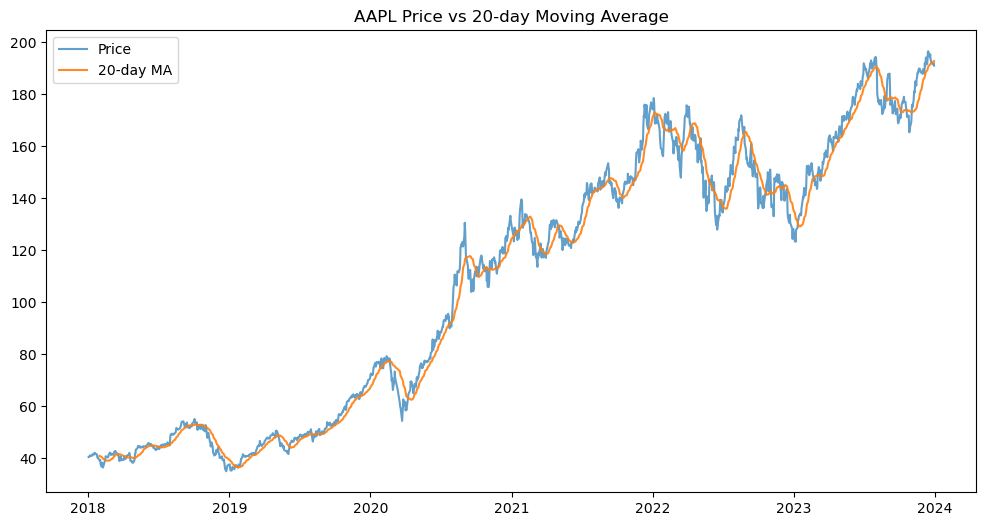

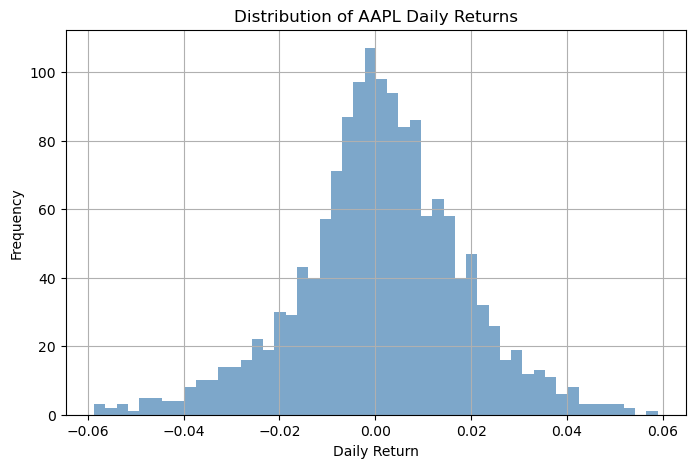

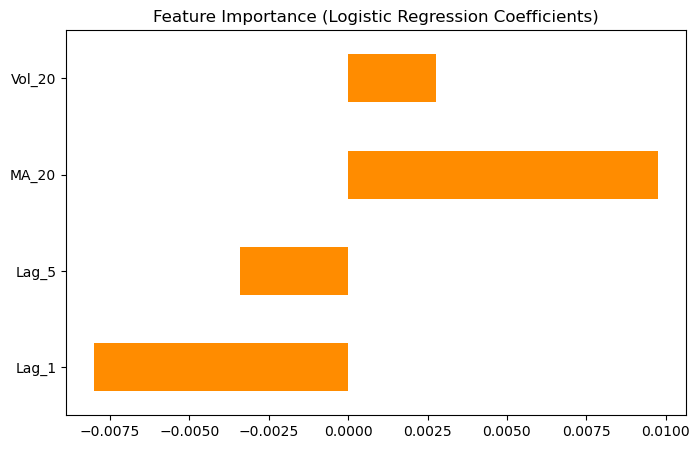

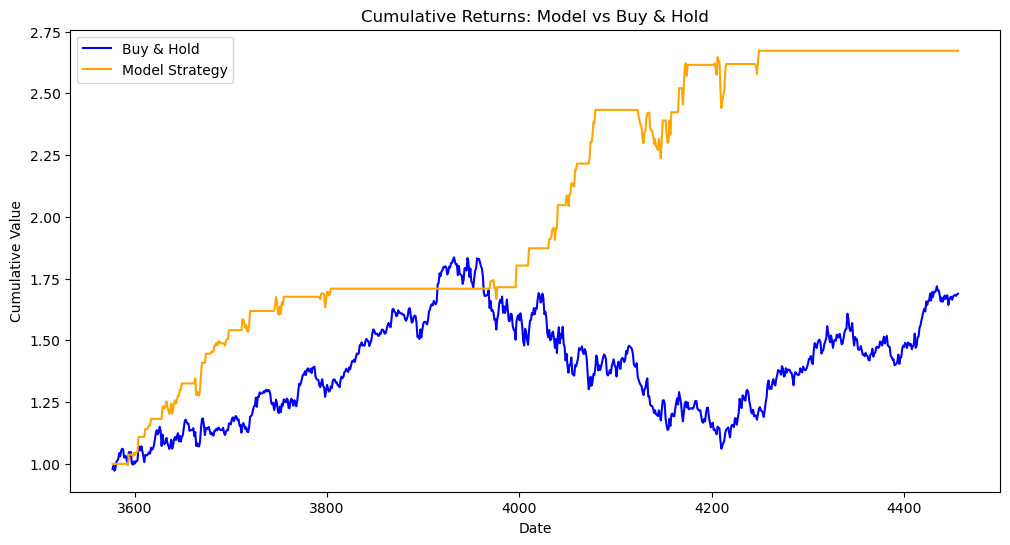

In [32]:
#1. Price vs Moving Average
aapl = stocks_final[stocks_final['Symbol']=="AAPL"].set_index("Date")

plt.figure(figsize=(12,6))
plt.plot(aapl.index, aapl['Price'], label="Price", alpha=0.7)
plt.plot(aapl.index, aapl['MA_20'], label="20-day MA", alpha=0.9)
plt.title("AAPL Price vs 20-day Moving Average")
plt.legend()
plt.show()


#2. Distribution of Returns
plt.figure(figsize=(8,5))
aapl['Return'].dropna().hist(bins=50, alpha=0.7, color="steelblue")
plt.title("Distribution of AAPL Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


#3. Feature Importance (Logistic Regression)
importance = pd.Series(model.coef_[0], index=X.columns)
importance.plot(kind="barh", figsize=(8,5), color="darkorange")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()


#4. Buy & Hold vs Model Strategy
# Add predictions to test set
X_test = X_test.copy()
X_test['Predicted'] = y_pred
X_test['Return'] = ml_data.loc[y_test.index, 'Return']

# Strategy: only invest on predicted up days
X_test['Strategy_Return'] = np.where(X_test['Predicted'] == 1, X_test['Return'], 0)

# Cumulative returns
buy_hold = (1 + X_test['Return']).cumprod()
strategy = (1 + X_test['Strategy_Return']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(buy_hold.index, buy_hold, label="Buy & Hold", color="blue")
plt.plot(strategy.index, strategy, label="Model Strategy", color="orange")
plt.title("Cumulative Returns: Model vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.show()

### 1. Price vs 20-day Moving Average (AAPL)
The chart of Apple’s price versus its 20-day moving average highlights how feature engineering captures underlying market trends. While the raw price data fluctuates daily, the moving average smooths these movements, showing periods of upward momentum and short-term corrections. This demonstrates how moving averages can enrich predictive models by encoding momentum and trend information.

### 2. Distribution of Daily Returns
The distribution of Apple’s daily returns confirms a central tendency around zero but with fat tails, meaning extreme events are more common than in a normal distribution. This aligns with financial market behavior, where volatility clustering and rare but impactful events drive risk. Such analysis not only confirms the stationary nature of returns but also highlights the inherent unpredictability of financial time series.

### 3. Feature Importance (Logistic Regression Coefficients)
The feature importance chart reveals that the 20-day moving average is the most influential predictor in the logistic regression model, while lagged price features have smaller and mixed effects. Volatility provides modest predictive power. This suggests that trend-based indicators contribute more meaningfully to prediction than short lags, aligning with the intuition that markets exhibit momentum effects.

### 4. Cumulative Returns: Model vs Buy & Hold
Finally, the cumulative returns comparison between the buy-and-hold strategy and the model strategy illustrates how predictions translate into practical outcomes. Although the model does not perfectly track market movements, there are periods where it outperforms by avoiding losses or capturing trends. This demonstrates the value of connecting machine learning outputs with real-world financial applications, even when predictive accuracy is modest.

# Exporting to MySQL

In [37]:
from sqlalchemy import create_engine

user = "root"
password = "Sweettea9"
host = "localhost:3306"
database = "finance_db"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

# Save dataframe to MySQL
stocks_final.to_sql("sp500_stocks", con=engine, if_exists="replace", index=False)

4457

# Conclusion

This project demonstrated an end-to-end workflow for financial time series analysis and predictive modeling, starting from data collection and preprocessing, through feature engineering and stationarity testing, and culminating in a machine learning model with practical evaluation. Using Apple’s stock data as a case study, I showed how engineered features such as moving averages, lagged prices, and volatility capture important market dynamics, while statistical tests confirmed that returns not raw prices are suitable for modeling. Logistic regression provided a baseline predictive model, with feature importance highlighting the value of trend indicators, and a trading simulation compared model-based strategies to buy-and-hold performance. While the model’s predictive power was modest, the pipeline illustrates how data analysis, machine learning, and financial interpretation can be integrated into a cohesive analytical framework. This approach can be extended to additional assets, more advanced models, or broader market analysis, making it both a practical demonstration of applied skills and a foundation for future work.